<a href="https://colab.research.google.com/github/chaeyeon00/Computer-Vision/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

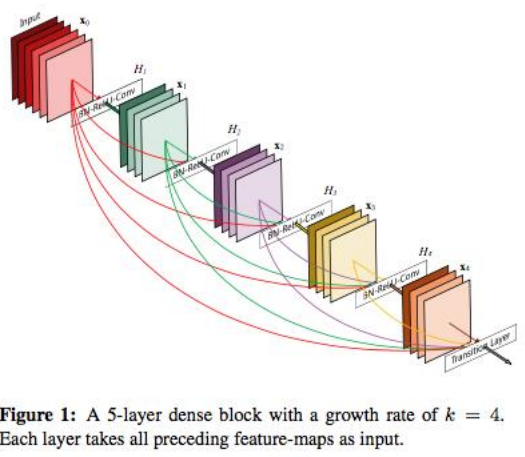


[참고] https://github.com/bamos/densenet.pytorch/blob/master/densenet.py 
https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py
https://deep-learning-study.tistory.com/545

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import torch.utils.data

# 이미지
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import utils
import matplotlib.pyplot as plt
# utils
import numpy as np
from torchsummary import summary
import time
import copy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


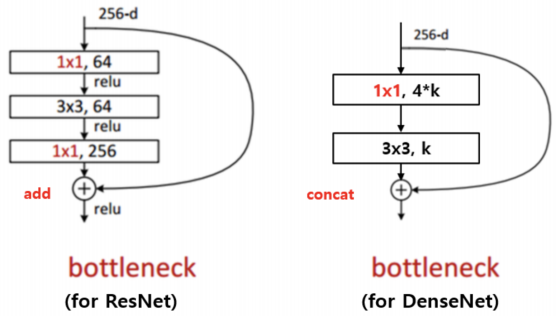

In [ ]:
"""
DenseNet BottleNeck
DesneNet 구조  BN - ReLU-Conv 
1*1 conv를 통하여 4*grow rate개의 feature map 생성
이후 3*3 conv를 통하여 grow rate개의 feautre map으로 갯수를 줄여준다.
"""
class BottleNeck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super().__init__()
        interChannels = 4 * growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels,interChannels,kernel_size = 1,padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size = 3,padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x,out),1)
        return out

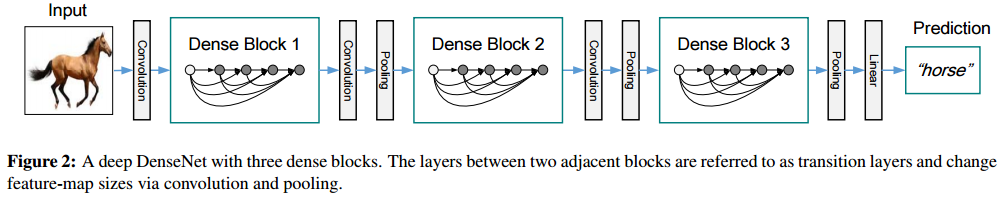

In [ ]:
"""
Transition Block
구조 BN  - Relu  -Conv(1,1)- 2*2 avg pooling
Densen block사이에서 pooling 연산을 수행하여 계속하여 늘어나는 feautre map의 크기와 채널 수를 감소,('GrowRate'를 통하여 조정)
"""
class Transition(nn.Module):
   def __init__(self, nChannels, growRate):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growRate, kernel_size=1, bias=False)

   def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

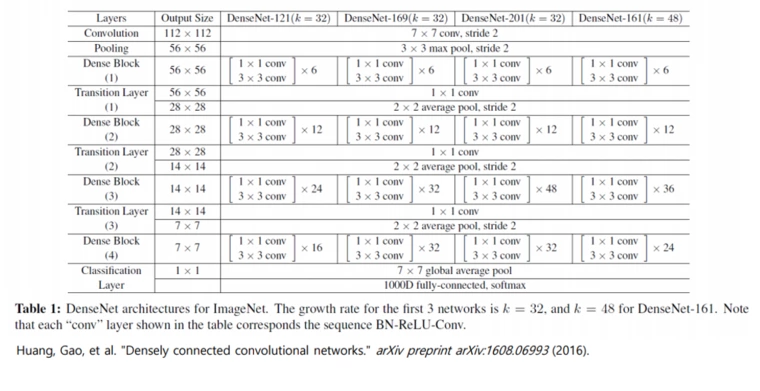

In [ ]:
# DenseNet
class DenseNet(nn.Module):
    def __init__(self, nblocks, growthRate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growthRate = growthRate
        nChannels = 2 * growthRate 

        # 첫번째 convolution [conv - BN - Rel -Pooling ]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, nChannels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(nChannels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Desne Block 생성
        self.features = nn.Sequential()
        # 샘플 nblocks - [6,12,24,16]
        #파라미터  nblocks의 리스트 사이즈 만큼의 Desne Block과 transition_layer 생성
        # 마지막 Desne Block을 제외하고 transition_layer 생성 및 out 채널 사이즈를 0.5 씩 줄임
        for i in range(len(nblocks)):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], nChannels))
            nChannels += growthRate * nblocks[i]
            if i != len(nblocks) - 1: 
              out_channels = int(reduction * nChannels)
              self.features.add_module('transition_layer_{}'.format(i), Transition(nChannels, out_channels))
              nChannels = out_channels 


        # 마지막 BN
        self.features.add_module('bn', nn.BatchNorm2d(nChannels))
      
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(nChannels, num_classes)

        # weight 초기화
        # 각 모듈의 layer 타입에 따른 weight 초기화 정의
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

          
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.features(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    #bottle_neck_layer 생성 , growthRate만큼 out늘어남
    def _make_dense_block(self, nblock, nChannels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(nChannels, self.growthRate))
            nChannels += self.growthRate
        return dense_block


In [ ]:
def densenet121():
    return DenseNet([6,12,24,16])

def densenet169():
    return DenseNet([6,12,32,32])

def densenet201():
    return DenseNet([6,12,48,32])

def densenet161():
    return DenseNet( [6,12,36,24])

In [ ]:
# 모델 확인
x = torch.randn(3, 3, 64, 64)
model = densenet121()
output = model(x)
print(output.size())
model.cuda()

torch.Size([3, 10])


DenseNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (dense_block_0): Sequential(
      (bottle_neck_layer_0): BottleNeck(
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bottle_neck_layer_1): BottleNeck(
        (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), b

**이미지불러오기**:

In [ ]:
# transformation 정의
# 이미지 정규화 수행
train_transformation = transforms.Compose([ 
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

val_transformation = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [ ]:
# CIFAR10 데이터 불러오기
path_Data = '/data'

train_ds = datasets.CIFAR10(root=path_Data, train=True, download=True, transform= train_transformation)
val_ds = datasets.CIFAR10(root=path_Data, train=False,  download=True, transform= train_transformation)

print(len(train_ds))
print(len(val_ds))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified
50000
10000


In [ ]:
# data 로드
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

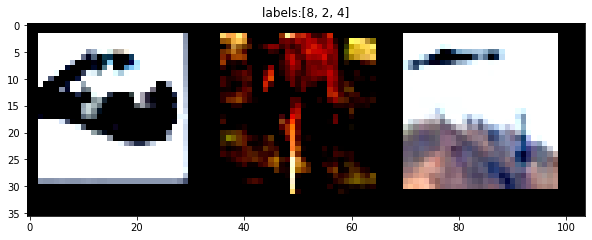

In [ ]:
# 데이터 확인
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(7)
torch.manual_seed(0)

grid_size=3
rnd_ind = np.random.randint(0, len(val_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

#loss function, optimizer, lr_scheduler, num_epoch 정의
# 논문에서는 CIFAR10의 경우 num_epoch = 300 으로 정의되었으나, 시간 으로 50으로 축소
initial_lr = 0.1
num_epoch = 50
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=opt, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)


In [ ]:
# train 시 필요한 파라미터 정의
params_train = {
    'num_epochs':num_epoch,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'lr_scheduler':lr_scheduler,
    'path_weights':'/data//models/weights.pt',
}

In [ ]:
# 매개변수 옵티마이저의 lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# 배치기준 metric 계산
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# 배치기준 loss 계산
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# epochs 기준 loss
#loss_epoch ->  loss_batch (배치당 loss 계산) -> metric_batch (배치당 metric 계산)
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b


    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    lr_scheduler=params['lr_scheduler']
    path_weights=params['path_weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    # state_dict : 각 layer마다 텐서로 매핑되는 매개변수를 python dictionary 타입으로 저장한 객체
    # copy.deepcopy : python의 깊은 복사를 의미, 각 layer들의 매개변수를 복사
    # best_model_wts : 모델의 초기  매개변수를 가져옴
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        # loss손실이 적은 경우, 현재 weights를 저장
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path_weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        # 현재 훈련 중인 lr와  옵티마이저의 lr이 다른 경우 weight loding
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/49, current lr= 0.1
Copied best model weights!
train loss: 0.024629, val loss: 0.023580, accuracy: 45.09, time: 1.2502 min
----------
Epoch 1/49, current lr= 0.1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Copied best model weights!
train loss: 0.022599, val loss: 0.021026, accuracy: 51.00, time: 2.5078 min
----------
Epoch 2/49, current lr= 0.1
Copied best model weights!
train loss: 0.021117, val loss: 0.020125, accuracy: 53.16, time: 3.7751 min
----------
Epoch 3/49, current lr= 0.1
Copied best model weights!
train loss: 0.019646, val loss: 0.019118, accuracy: 56.37, time: 5.1014 min
----------
Epoch 4/49, current lr= 0.1
Copied best model weights!
train loss: 0.018217, val loss: 0.018081, accuracy: 58.93, time: 6.4381 min
----------
Epoch 5/49, current lr= 0.1
Copied best model weights!
train loss: 0.016956, val loss: 0.017388, accuracy: 60.66, time: 7.7716 min
----------
Epoch 6/49, current lr= 0.1
Copied best model weights!
train loss: 0.015904, val loss: 0.015519, accuracy: 64.97, time: 9.1780 min
----------
Epoch 7/49, current lr= 0.1
train loss: 0.015023, val loss: 0.015632, accuracy: 65.18, time: 10.6231 min
----------
Epoch 8/49, current lr= 0.1
Copied best model weights!
train

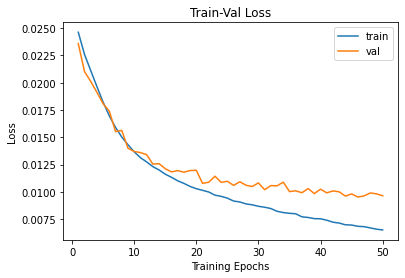

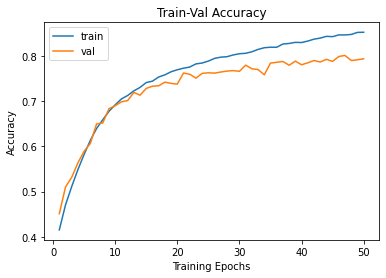

In [ ]:
# num_epochs 추출
num_epochs = params_train['num_epochs']

# loss 그래프
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# accuracy 그래프
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()